In [11]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn

### Import training data

In [12]:
train_df = pd.read_csv('bank_train.csv')

### Initial analysis

In [13]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


male married graduate in the rural was rejected it seems because of 1 dependant.

In [14]:
# Format column naming consistency
train_df.columns = ['loan id','gender','married','dependants','education',
                    'self employed','applicant income',
                    'co applicant income','loan amount','loan amount term',
                    'credit history','property area','loan status']

### Column observation

In [15]:
train_df.dtypes

loan id                 object
gender                  object
married                 object
dependants              object
education               object
self employed           object
applicant income         int64
co applicant income    float64
loan amount            float64
loan amount term       float64
credit history         float64
property area           object
loan status             object
dtype: object

<AxesSubplot:>

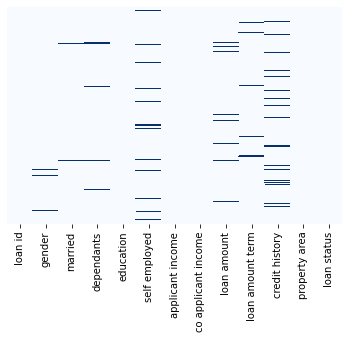

In [16]:
sn.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap="Blues")

# Preprocess

In [17]:
print(train_df.isna().sum()) 

loan id                 0
gender                 13
married                 3
dependants             15
education               0
self employed          32
applicant income        0
co applicant income     0
loan amount            22
loan amount term       14
credit history         50
property area           0
loan status             0
dtype: int64


I chose not to remove all the nulls because the data reduces significantly if so

Credit history loan amount and loan amount term seem to be impotant, the other columns containing nulls can be placed into the no optinon of a binary case, credit history will be filled with zeros

### Test credit history significance

In [18]:
train_df["credit history"].unique()

array([ 1.,  0., nan])

In [19]:
# find some significance from credit history
temp = train_df[train_df["credit history"] == 1]
temp2 = train_df[train_df["credit history"] == 0]
print('credit history 1 = Y', len(temp[temp['loan status'] =='Y']))
print('credit history 0 = Y', len(temp2[temp2['loan status'] =='Y']))

print('credit history 1 = N', len(temp[temp['loan status'] =='N']))
print('credit history 0 = N', len(temp2[temp2['loan status'] =='N']))

credit history 1 = Y 378
credit history 0 = Y 7
credit history 1 = N 97
credit history 0 = N 82


finding: 1 in credit history results in higher probability of achieving loan.

In [20]:
# here is a frame showing succesful applicants with 0 credit history
temp2[temp2['loan status'] =='Y']

,loan id,gender,married,dependants,education,self employed,applicant income,co applicant income,loan amount,loan amount term,credit history,property area,loan status
122,LP001431,Female,No,0,Graduate,No,2137,8980.0,137.0,360.0,0.0,Semiurban,Y
155,LP001536,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
201,LP001677,Male,No,2,Graduate,No,4923,0.0,166.0,360.0,0.0,Semiurban,Y
267,LP001882,Male,Yes,3+,Graduate,No,4333,1811.0,160.0,360.0,0.0,Urban,Y
326,LP002068,Male,No,0,Graduate,No,4917,0.0,130.0,360.0,0.0,Rural,Y
453,LP002449,Male,Yes,0,Graduate,No,2483,2466.0,90.0,180.0,0.0,Rural,Y
527,LP002706,Male,Yes,1,Not Graduate,No,5285,1430.0,161.0,360.0,0.0,Semiurban,Y


### Convert and clean binary columns

In [21]:
# change column to binary and fill nulls with zeros
train_df['credit history'] = train_df['credit history'].fillna(0).astype(int)
train_df['loan amount term'] = train_df['loan amount term'].fillna(0)
train_df['loan amount'] = train_df['loan amount'].fillna(0)

In [22]:
# change to binary married column

temp = pd.get_dummies(train_df['married'])
temp = temp.drop('No',axis=1)
temp = temp.rename(columns = {'Yes':'married'})
train_df = train_df.drop('married',axis=1)
train_df = pd.concat((train_df, temp), axis = 1)


In [23]:
# change to binary education column
temp = pd.get_dummies(train_df['education'])
temp = temp.drop('Not Graduate',axis=1)
temp = temp.rename(columns = {'Graduate':'graduate'})
train_df = train_df.drop('education',axis=1)
train_df = pd.concat((train_df, temp), axis = 1)


In [24]:
train_df.columns

Index(['loan id', 'gender', 'dependants', 'self employed', 'applicant income',
       'co applicant income', 'loan amount', 'loan amount term',
       'credit history', 'property area', 'loan status', 'married',
       'graduate'],
      dtype='object')

In [25]:
# change self employed to binary

temp = pd.get_dummies(train_df['self employed'])
temp = temp.drop('No',axis=1)
temp = temp.rename(columns = {'Yes':'self employed'})
train_df = train_df.drop('self employed',axis=1)
train_df = pd.concat((train_df, temp), axis = 1)


In [26]:
# check remaining nans
print('\ncleaned data frame', train_df.isna().sum())


cleaned data frame loan id                 0
gender                 13
dependants             15
applicant income        0
co applicant income     0
loan amount             0
loan amount term        0
credit history          0
property area           0
loan status             0
married                 0
graduate                0
self employed           0
dtype: int64


clear the addition sign in dependants category and convert column to int

I couldnt convert float nan to integer so before i remove it i shall find whether i shall fill na with 0 or remove because this may be important considering loans

In [27]:
train_df

,loan id,gender,dependants,applicant income,co applicant income,loan amount,loan amount term,credit history,property area,loan status,married,graduate,self employed
0,LP001002,Male,0,5849,0.0,0.0,360.0,1,Urban,Y,0,1,0
1,LP001003,Male,1,4583,1508.0,128.0,360.0,1,Rural,N,1,1,0
2,LP001005,Male,0,3000,0.0,66.0,360.0,1,Urban,Y,1,1,1
3,LP001006,Male,0,2583,2358.0,120.0,360.0,1,Urban,Y,1,0,0
4,LP001008,Male,0,6000,0.0,141.0,360.0,1,Urban,Y,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,0,2900,0.0,71.0,360.0,1,Rural,Y,0,1,0
610,LP002979,Male,3+,4106,0.0,40.0,180.0,1,Rural,Y,1,1,0
611,LP002983,Male,1,8072,240.0,253.0,360.0,1,Urban,Y,1,1,0
612,LP002984,Male,2,7583,0.0,187.0,360.0,1,Urban,Y,1,1,0


### check dependents column

In [28]:
temp = train_df[train_df['dependants']=='0']# i changed this string entry to check the unique variables among dependants column
train_df.groupby('dependants').size()

dependants
0     345
1     102
2     101
3+     51
dtype: int64

It actually shows that people with 0 dependants are more likey to recieve loans than others with more dependants. so i dont want to give an advantage to those that do not complete this entry. and will remove the rest of the nulls from here and encode the remaning colums

In [29]:
# change loan status to binary

temp = pd.get_dummies(train_df['loan status'])
temp = temp.drop('N',axis=1)
temp = temp.rename(columns = {'Y':'loan status'})
train_df = train_df.drop('loan status',axis=1)
train_df = pd.concat((train_df, temp), axis = 1)


Gender is removed and remaining nulls are dropped then depenndants column is cleaned 

In [30]:
#drop gender
train_df = train_df.drop('gender', axis=1)
#drop remaining nulls
#train_df = train_df.dropna()
# drop loan id
train_df = train_df.drop('loan id', axis=1)

In [31]:

# make a copy and remove the addition sign
temp = train_df['dependants'].str.replace('+','')
# convert copy to int
temp = temp.astype(float) 
# delete original
train_df = train_df.drop(['dependants'], axis = 1)
# concat copy to replace original
train_df = pd.concat((temp, train_df), axis=1) 

<ipython-input-31-a662ada7002c>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp = train_df['dependants'].str.replace('+','')


In [32]:
train_df['dependants'] = train_df['dependants'].fillna(3.0)

In [33]:
# final check
train_df.isna().sum()

dependants             0
applicant income       0
co applicant income    0
loan amount            0
loan amount term       0
credit history         0
property area          0
married                0
graduate               0
self employed          0
loan status            0
dtype: int64

In [34]:
train_df.dtypes

dependants             float64
applicant income         int64
co applicant income    float64
loan amount            float64
loan amount term       float64
credit history           int32
property area           object
married                  uint8
graduate                 uint8
self employed            uint8
loan status              uint8
dtype: object

In [35]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# encode property area
train_df['property area'] = encoder.fit_transform(train_df['property area'].astype(str))

In [36]:
train_df.dtypes

dependants             float64
applicant income         int64
co applicant income    float64
loan amount            float64
loan amount term       float64
credit history           int32
property area            int32
married                  uint8
graduate                 uint8
self employed            uint8
loan status              uint8
dtype: object

## specify input and target

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as metrics
%matplotlib inline

# X contains the determining features that provide the outcome y
X= train_df[['dependants', 'married','graduate','self employed','applicant income','co applicant income'
                     ,'loan amount','loan amount term','credit history','property area']]
# Loan status is t=our required outcome
y = train_df['loan status']

## Split for model training and evaluation testing

In [38]:
# Split the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3) # 80%

### Build Models

In [39]:
# Import Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 

# Build the Logistiic regression classifier
LR = LogisticRegression(max_iter=100,C=10.0,solver = 'liblinear', random_state=3)
# Build the Decision tree classifier
DT = DecisionTreeClassifier(criterion='gini',max_depth=2)
# Build the random forest classifier
RF = RandomForestClassifier(n_estimators=200, max_depth=3)


In [40]:
# fit each model
LR_model = LR.fit(X_train, y_train)
DT_model = DT.fit(X_train, y_train)
RF_model = RF.fit(X_train, y_train)

In [41]:
# predict 
LR_pred = LR_model.predict(X_test) 
DT_pred = DT_model.predict(X_test) 
RF_pred = RF_model.predict(X_test) 

I managed to optimize the model accuracy and concluded my initial model test with all most identical results. the random forest one varies slighly

## Evaluation

In [42]:
# compare the test prediction accuracy
print(accuracy_score(y_test, LR_pred))
print(accuracy_score(y_test, DT_pred))
print(accuracy_score(y_test, RF_pred))

0.8048780487804879
0.8048780487804879
0.8048780487804879


In [43]:
print('LR\n',confusion_matrix(y_test, LR_pred),'\n')
print('DT\n',confusion_matrix(y_test, DT_pred),'\n')
print('RF\n',confusion_matrix(y_test, RF_pred))

LR
 [[13 15]
 [ 9 86]] 

DT
 [[12 16]
 [ 8 87]] 

RF
 [[13 15]
 [ 9 86]]


In [44]:
from sklearn.metrics import recall_score as rs
from sklearn.metrics import precision_score as ps
from sklearn.metrics import f1_score as fs
from sklearn.metrics import balanced_accuracy_score as bas

LR_recall = rs(y_test,LR_pred)
LR_precision = ps(y_test,LR_pred)
LR_f1 = fs(y_test,LR_pred)
LR_ma = LR_model.score(X_test,y_test)

DT_recall = rs(y_test,DT_pred)
DT_precision = ps(y_test,DT_pred)
DT_f1 = fs(y_test,DT_pred)
DT_ma = DT_model.score(X_test,y_test)

RF_recall = rs(y_test,RF_pred)
RF_precision = ps(y_test,RF_pred)
RF_f1 = fs(y_test,RF_pred)
RF_ma = RF_model.score(X_test,y_test)


In [45]:
print('\n*** Logistic Regression Evaluation metrics for test dataset ***')
print('Recall Score: ',LR_recall)
print('Precision Score: ',LR_precision)
print('F1 Score: ',LR_f1)
print('Accuracy: ',LR_ma)

print('\n*** Decision Tree Evaluation metrics for test dataset ***')
print('Recall Score: ',DT_recall)
print('Precision Score: ',DT_precision)
print('F1 Score: ',DT_f1)
print('Accuracy: ',DT_ma)

print('\n*** Random Forest Evaluation metrics for test dataset ***')
print('Recall Score: ',RF_recall)
print('Precision Score: ',RF_precision)
print('F1 Score: ',RF_f1)
print('Accuracy: ',RF_ma)


*** Logistic Regression Evaluation metrics for test dataset ***
Recall Score:  0.9052631578947369
Precision Score:  0.8514851485148515
F1 Score:  0.8775510204081632
Accuracy:  0.8048780487804879

*** Decision Tree Evaluation metrics for test dataset ***
Recall Score:  0.9157894736842105
Precision Score:  0.8446601941747572
F1 Score:  0.8787878787878788
Accuracy:  0.8048780487804879

*** Random Forest Evaluation metrics for test dataset ***
Recall Score:  0.9052631578947369
Precision Score:  0.8514851485148515
F1 Score:  0.8775510204081632
Accuracy:  0.8048780487804879


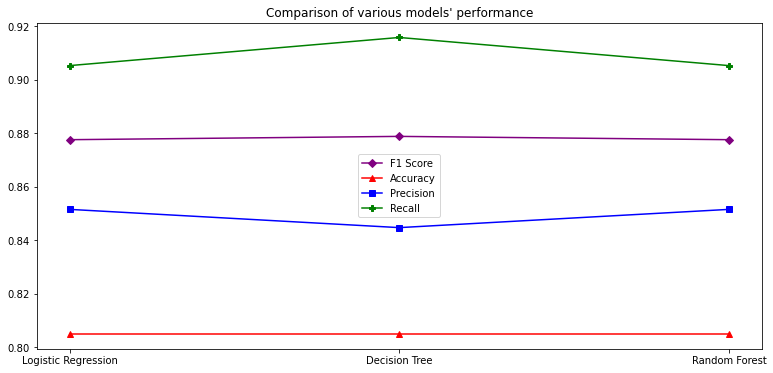

In [46]:
#import matplotlib.pyplot as plt
fig = plt.figure(figsize=(13,6))
#plt.bar(['Logistic Regression','Decision Tree','Random Forest'],[LR_f1,DT_f1,RF_f1],color=['red','green','purple','orange','Blue'])
plt.plot(['Logistic Regression','Decision Tree','Random Forest'],[LR_f1,DT_f1,RF_f1],color='purple',marker='D')
plt.plot(['Logistic Regression','Decision Tree','Random Forest'],[LR_ma,DT_ma,RF_ma],color='red',marker='^')
plt.plot(['Logistic Regression','Decision Tree','Random Forest'],[LR_precision,DT_precision,RF_precision],color='blue',marker='s')
plt.plot(['Logistic Regression','Decision Tree','Random Forest'],[LR_recall,DT_recall,RF_recall],color='green',marker='P')
plt.legend(('F1 Score','Accuracy','Precision','Recall'))
plt.title('Comparison of various models\' performance')

plt.show(fig)

### Feature optimization Decision tree

In [47]:
# check Important features Decision tree
feature_importances_df = pd.DataFrame(
    {"feature": X.columns, "importance": DT.feature_importances_}
).sort_values("importance", ascending=False)

# Display
feature_importances_df

,feature,importance
8,credit history,0.896373
9,property area,0.060285
6,loan amount,0.043342
0,dependants,0.000000
1,married,0.000000
2,graduate,0.000000
3,self employed,0.000000
4,applicant income,0.000000
5,co applicant income,0.000000
7,loan amount term,0.000000


### Feature optuimized decision tree model

In [48]:
# X contains the determining features that provide the outcome y
dt_X= train_df[['applicant income','property area','credit history']]
# Loan status is t=our required outcome
dt_y = train_df['loan status']

# Split the training and test set
X_train, X_test, y_train, y_test = train_test_split(dt_X, dt_y, test_size=0.2, random_state=3) # 80%

DT = DecisionTreeClassifier(criterion='gini',max_depth=2)
DT_model = DT.fit(X_train, y_train)
DT_pred = DT_model.predict(X_test) 
print("DT Accuracy:",accuracy_score(y_test, DT_pred))

DT Accuracy: 0.8048780487804879


This didnt change....

### Feature optimization Random forest

In [49]:
# check Important features Random forest
feature_importances_df = pd.DataFrame(
    {"feature": X.columns, "importance": RF.feature_importances_}
).sort_values("importance", ascending=False)

# Display
feature_importances_df

,feature,importance
8,credit history,0.518719
6,loan amount,0.123897
4,applicant income,0.099043
5,co applicant income,0.094912
9,property area,0.060224
7,loan amount term,0.038117
0,dependants,0.023987
2,graduate,0.022301
1,married,0.012234
3,self employed,0.006566


In [50]:
# new input features

# X contains the determining features that provide the outcome y
rf_X= train_df[['applicant income','co applicant income'
                     ,'loan amount','loan amount term','credit history', 'dependants', 'married']]
# Loan status is t=our required outcome
rf_y = train_df['loan status']

In [51]:
# Split the training and test set
X_train, X_test, y_train, y_test = train_test_split(rf_X, rf_y, test_size=0.2, random_state=3) # 80%

In [52]:
# fit each model
RF_model = RF.fit(X_train, y_train)

In [53]:
RF_pred = RF_model.predict(X_test) 
print("RF Accuracy:",accuracy_score(y_test, RF_pred))


RF Accuracy: 0.7967479674796748


This didnt change much it varies up and down between 81 and 78 percent.....


## Predict test set

In [54]:
test_df = pd.read_csv('bank_test.csv')

test_df['loan status'] = 0
test_df.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
loan status           0
dtype: int64

### CLeaning

In [55]:
# Format column naming consistency to go through the training
test_df.columns = ['loan id','gender','married','dependants','education',
                    'self employed','applicant income',
                    'co applicant income','loan amount','loan amount term',
                    'credit history','property area','loan status']

In [56]:
def preprocess(train_df):# change column to binary and fill nulls with zeros
    train_df['credit history'] = train_df['credit history'].fillna(0).astype(int)
    train_df['loan amount term'] = train_df['loan amount term'].fillna(0)
    train_df['loan amount'] = train_df['loan amount'].fillna(0)

    # change to binary married column
    temp = pd.get_dummies(train_df['married'])
    temp = temp.drop('No',axis=1)
    temp = temp.rename(columns = {'Yes':'married'})
    train_df = train_df.drop('married',axis=1)
    train_df = pd.concat((train_df, temp), axis = 1)

    # change to binary education column
    temp = pd.get_dummies(train_df['education'])
    temp = temp.drop('Not Graduate',axis=1)
    temp = temp.rename(columns = {'Graduate':'graduate'})
    train_df = train_df.drop('education',axis=1)
    train_df = pd.concat((train_df, temp), axis = 1)

    # change self employed to binary

    temp = pd.get_dummies(train_df['self employed'])
    temp = temp.drop('No',axis=1)
    temp = temp.rename(columns = {'Yes':'self employed'})
    train_df = train_df.drop('self employed',axis=1)
    train_df = pd.concat((train_df, temp), axis = 1)

    #drop gender
    train_df = train_df.drop('gender', axis=1)
    #drop remaining nulls
    #train_df = train_df.dropna()
    # drop loan id
    train_df = train_df.drop('loan id', axis=1)

    # make a copy and remove the addition sign
    temp = train_df['dependants'].str.replace('+','')
    # convert copy to int
    temp = temp.astype(float) 
    # delete original
    train_df = train_df.drop(['dependants'], axis = 1)
    # concat copy to replace original
    train_df = pd.concat((temp, train_df), axis=1) 
    # fill nan
    train_df['dependants'] = train_df['dependants'].fillna(3.0)

    # encode property area
    train_df['property area'] = encoder.fit_transform(train_df['property area'].astype(str))
    return train_df

In [57]:
cleaned_test_df = preprocess(test_df)
X2= cleaned_test_df[['applicant income','co applicant income'
                     ,'loan amount','loan amount term','credit history', 'dependants', 'married']]
X1= cleaned_test_df[['dependants', 'applicant income', 'co applicant income', 'loan amount',
       'loan amount term', 'credit history', 'property area', 
       'married', 'graduate', 'self employed']]

<ipython-input-56-0bd269486b28>:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp = train_df['dependants'].str.replace('+','')


In [58]:
cleaned_test_df.columns

Index(['dependants', 'applicant income', 'co applicant income', 'loan amount',
       'loan amount term', 'credit history', 'property area', 'loan status',
       'married', 'graduate', 'self employed'],
      dtype='object')

In [59]:
RF_loan_pred = RF_model.predict(X2)
RF_loan_pred = pd.DataFrame(RF_loan_pred,columns = ['rf loan prediction'])
LR_loan_pred = LR_model.predict(X1)
LR_loan_pred = pd.DataFrame(LR_loan_pred,columns = ['lr loan prediction'])

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [60]:
pred_df = pd.concat((test_df, RF_loan_pred), axis = 1)
pred_df = pd.concat((pred_df, LR_loan_pred), axis = 1)

In [61]:
pred_df = pred_df.drop('loan status', axis =1)
pred_df

,loan id,gender,married,dependants,education,self employed,applicant income,co applicant income,loan amount,loan amount term,credit history,property area,rf loan prediction,lr loan prediction
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1,Urban,1,1
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1,Urban,1,1
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1,Urban,1,1
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,0,Urban,0,1
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1,Urban,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1,Urban,1,1
363,LP002975,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1,Urban,1,1
364,LP002980,Male,No,0,Graduate,No,3250,1993,126.0,360.0,0,Semiurban,0,1
365,LP002986,Male,Yes,0,Graduate,No,5000,2393,158.0,360.0,1,Rural,1,1


# Summary

 Logistic regression and Random forest are the most interesting. Rf said no to ones Decision tree said yes to.